In [1]:
import sys

import pandas as pd

PWD = '../../..'
sys.path.append(PWD)

import pickle
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from src.cfd import CFD, find_optimal_cfd_threshold
from src.gauss_hist import get_gauss_stats
from src.network_utils import plot_difference_hist, compare_results

In [2]:
N_JOBS = 8

DATASET_PATH = '../../../data/dataset/dataset.pkl'

PRINT_PCOV = False

N_BASELINE = 8

CFD_THRESHOLD_SPACE = np.arange(0.12, 0.25, 0.005)
OPTIMAL_CFD_THRESHOLDS_ALL_DATA_PATH = '../../../data/tmp/many_channels_tests/optimal_cfd_thresholds_all_data.pkl'

PLANE = 2
CHANNEL = 11

In [3]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

In [4]:
x_time = np.arange(0, 24 / 7.695, 1 / 7.695)
x_time.shape

(24,)

# Utils

In [5]:
def load_model(model, name, path_component='basic_tests', root='..'):
    model.load_weights(f'{root}/model_weights/{path_component}/{name}/weights')
    history = pd.read_csv(f'{root}/model_weights/{path_component}/{name}/loss_log.csv')

    return history

In [6]:
model_name = 'UNet'

def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D()(skip)
    return skip, x

def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    return x

def create_model():
    inputs = layers.Input(24)
    x = layers.Reshape((-1, 1))(inputs)

    skip1, x = conv_block(x, 64)
    skip2, x = conv_block(x, 128)
    skip3, x = conv_block(x, 256)
    x, _ = conv_block(x, 512)

    x = deconv_block(x, skip3, 256)
    x = deconv_block(x, skip2, 128)
    x = deconv_block(x, skip1, 64)

    x = layers.Conv1D(1, 1, activation='linear')(x)

    outputs = layers.Flatten()(x)

    model = tf.keras.Model(inputs, outputs)
    return model

def model_predict(model, X):
    Y_heatmap_pred = model.predict(X)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(np.arange(24), y, a_0=1, std_0=1.)

    return y_pred

def cfd_predict(cfd, X):
    y_pred = []
    for x in X:
        y_pred.append(cfd.predict(x_time, x))

    y_pred = np.array(y_pred)
    return y_pred

# Find optimal CFD thresholds

In [7]:
# optimal_cfd_thresholds = {}
# for plane, channel in sorted(dataset.keys()):
#     print(f'Processing p={plane}, ch={channel}...')
#     X, y = dataset[(plane, channel)][0], dataset[(plane, channel)][1]
#
#     optimal_cfd_threshold = find_optimal_cfd_threshold(CFD_THRESHOLD_SPACE, N_BASELINE, X, y, x_time, n_jobs=N_JOBS, plot=False)
#     optimal_cfd_thresholds[(plane, channel)] = optimal_cfd_threshold
#
# with open(OPTIMAL_CFD_THRESHOLDS_ALL_DATA_PATH, 'wb') as file:
#     pickle.dump(optimal_cfd_thresholds, file)

In [8]:
with open(OPTIMAL_CFD_THRESHOLDS_ALL_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.180
(1, 11): 0.180
(2,  2): 0.225
(2, 11): 0.145
(3,  2): 0.130
(3, 11): 0.170


# Load the model

In [9]:
model = create_model()
history = load_model(model, model_name)

# Test

Processing p=1, ch=2...
488/488 [==============================] - 4s 3ms/step


C:\Users\MatiX\anaconda3\envs\cern-py310\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 74.09 ps
      UNet: 69.48 ps (improvement: 6.23 %)
Processing p=1, ch=11...
821/821 [==============================] - 3s 3ms/step
       CFD: 87.92 ps
      UNet: 82.58 ps (improvement: 6.08 %)
Processing p=2, ch=2...
490/490 [==============================] - 2s 4ms/step
       CFD: 77.22 ps
      UNet: 70.05 ps (improvement: 9.29 %)
Processing p=3, ch=2...
487/487 [==============================] - 2s 4ms/step
       CFD: 85.63 ps
      UNet: 78.67 ps (improvement: 8.13 %)
Processing p=3, ch=11...
822/822 [==============================] - 3s 3ms/step
       CFD: 113.69 ps
      UNet: 105.95 ps (improvement: 6.80 %)


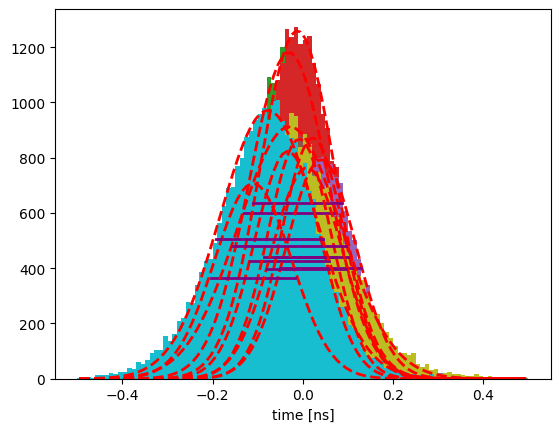

In [10]:
improvements = {}
for plane, channel in sorted(dataset.keys()):
    if (plane, channel) != (PLANE, CHANNEL):
        print(f'Processing p={plane}, ch={channel}...')
        X, y = dataset[(plane, channel)][0], dataset[(plane, channel)][1]

        cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
        y_pred_cfd = cfd_predict(cfd, X)
        std_cfd, _, _ = plot_difference_hist(y, y_pred_cfd, show=False)

        y_pred_model = model_predict(model, X)
        std_model, _, _ = plot_difference_hist(y, y_pred_model, show=False)

        compare_results([std_model], [model_name], std_cfd)
        improvements[(plane, channel)] = 1 - std_model / std_cfd

In [11]:
print('Improvements:')
for (plane, channel), improv in improvements.items():
    print(f'({plane:>1}, {channel:>2}): {improv * 100:0.2f} %')

Improvements:
(1,  2): 6.23 %
(1, 11): 6.08 %
(2,  2): 9.29 %
(3,  2): 8.13 %
(3, 11): 6.80 %
